In [ ]:
# %tensorflow_version 2.x

import warnings 
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_dir='/content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Train'
validation_dir='/content/drive/MyDrive/OralCancer/Final/Phase 1/Tongue/Val'
train_cancer=os.path.join(train_dir,'Cancer')
train_noncancer=os.path.join(train_dir,'Non-Cancer')
val_cancer=os.path.join(validation_dir,'Cancer')
val_noncancer=os.path.join(validation_dir,'Non-Cancer')

Mounted at /content/drive


In [ ]:
train_c=os.listdir(train_cancer)
train_nc=os.listdir(train_noncancer)
val_c=os.listdir(val_cancer)
val_nc=os.listdir(val_noncancer)

print(len(train_c))
print(len(train_nc))
print(len(val_c))
print(len(val_nc))

95
185
31
63


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
# pip install tensorflow_addons
import tensorflow_addons as tfa


def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    # create RAdam optimizer
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import MobileNet, MobileNetV2
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.applications import InceptionV3 
from tensorflow.keras.applications import EfficientNetV2B3
def build_model():
  base_model = EfficientNetV2B3(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  # optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer=Ranger()

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

  model.summary()
  
  return model

In [ ]:
model=build_model()

52617216/52606240 [==============================] - 0s 0us/step
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  0          ['rescaling_3[0][0]']            
 )                                                                                                
                          

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='binary',
    target_size=(224,224)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=16,
    class_mode='binary',
    target_size=(224,224)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 23s 2s/step - loss: 0.7039 - accuracy: 0.3281 - val_loss: 0.7592 - val_accuracy: 0.2812
Epoch 2/20
4/4 [==============================] - 4s 1s/step - loss: 0.7012 - accuracy: 0.3281 - val_loss: 0.7606 - val_accuracy: 0.3125
Epoch 3/20
4/4 [==============================] - 4s 1s/step - loss: 0.6875 - accuracy: 0.6016 - val_loss: 0.7676 - val_accuracy: 0.2656
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.6772 - accuracy: 0.6641 - val_loss: 0.7266 - val_accuracy: 0.3438
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.6677 - accuracy: 0.6641 - val_loss: 0.7123 - val_accuracy: 0.2969
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.6696 - accuracy: 0.6328 - val_loss: 0.6927 - val_accuracy: 0.6094
Epoch 7/20
4/4 [==============================] - 4s 1s/step - loss: 0.6573 - accuracy: 0.6484 - val_loss: 0.6569 - val_accuracy: 0.7812
Epoch 8/20
4/4 [========================

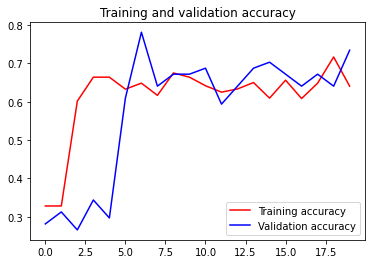

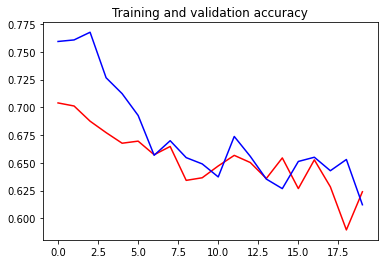

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')

plt.show()

In [ ]:
# Adam
def build_model2():
  base_model = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

  model.summary()
  
  return model

In [ ]:
model=build_model2()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 7s 1s/step - loss: 2.2787 - accuracy: 0.6172 - val_loss: 0.6760 - val_accuracy: 0.4688
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.6594 - accuracy: 0.6000 - val_loss: 0.4439 - val_accuracy: 0.7969
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.4415 - accuracy: 0.7812 - val_loss: 0.2844 - val_accuracy: 0.8438
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.1534 - accuracy: 0.9609 - val_loss: 0.2897 - val_accuracy: 0.9062
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.1584 - accuracy: 0.9219 - val_loss: 0.6826 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.0876 - accuracy: 0.9688 - val_loss: 0.3187 - val_accuracy: 0.9219
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 0.4938 - val_accuracy: 0.7969
Epoch 8/20
4/4 [=========================

In [ ]:
# SGD
def build_model3():
  base_model = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  output = layers.GlobalAveragePooling2D()(base_model.output)
  output = layers.Dense(2, activation='softmax')(output)
  model = Model(base_model.input, output)

  for layer in base_model.layers[:-4]:
      layer.trainable=False

  optimizer = tf.keras.optimizers.SGD(0.001)

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])

  model.summary()
  
  return model

In [ ]:
model=build_model3()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 7s 1s/step - loss: 0.6988 - accuracy: 0.6250 - val_loss: 0.6266 - val_accuracy: 0.7188
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 0.6246 - accuracy: 0.6797 - val_loss: 0.5907 - val_accuracy: 0.7188
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.5901 - accuracy: 0.6953 - val_loss: 0.6188 - val_accuracy: 0.6719
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.5527 - accuracy: 0.6750 - val_loss: 0.6293 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.5637 - accuracy: 0.6328 - val_loss: 0.5670 - val_accuracy: 0.6875
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.4885 - accuracy: 0.7250 - val_loss: 0.5540 - val_accuracy: 0.6875
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.4680 - accuracy: 0.7031 - val_loss: 0.5642 - val_accuracy: 0.6562
Epoch 8/20
4/4 [=========================

# Model Interpretability

In [ ]:
outputs = [layer.output for layer in model.layers[1:18]]
vis_model = Model(model.input, outputs)
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])
    print("Layers that will be used for visualization: ")
    print(layer_names)

Layers that will be used for visualization: 
['block1_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1']
Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2']
Layers that will be used for visualization: 
['block1_conv1', 'bl

In [ ]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        tape.watch(conv_output_values)
        pred_prob = predictions[:,1] 
        
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        smoothing = 0.00001 
        
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_sample(idx=None):
    
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]

    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import scipy as sp
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/3,224/3, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'cancer' if round(results[0][0]) else 'non cancer'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (224,224)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)


sigmoid output: [[3.5490433e-04 9.9964511e-01]]
prediction: non cancer


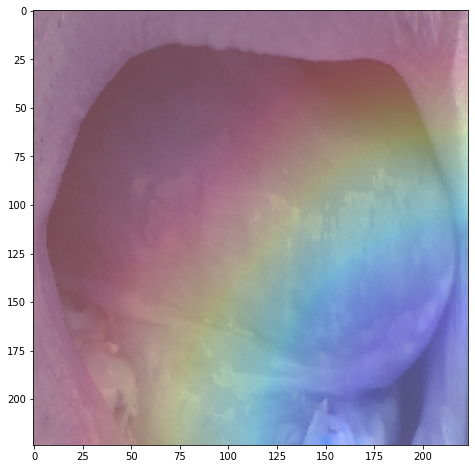

sigmoid output: [[1.0822678e-13 1.0000000e+00]]
prediction: non cancer


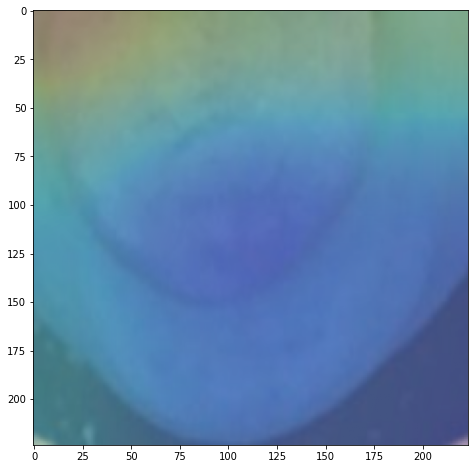

sigmoid output: [[2.4550702e-11 1.0000000e+00]]
prediction: non cancer


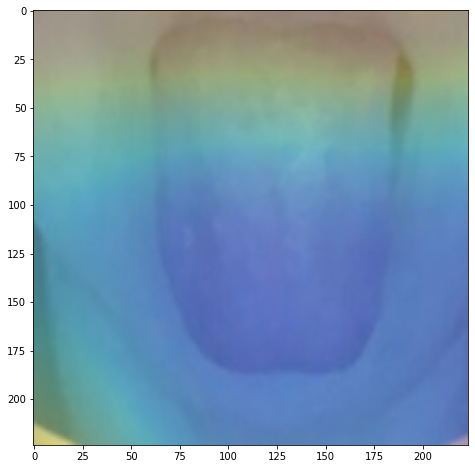

sigmoid output: [[3.8047045e-05 9.9996197e-01]]
prediction: non cancer


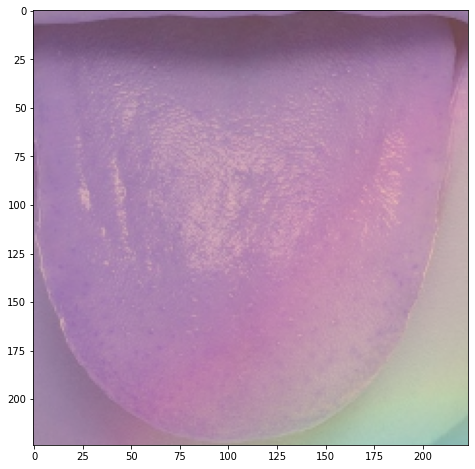

sigmoid output: [[4.0492457e-12 1.0000000e+00]]
prediction: non cancer


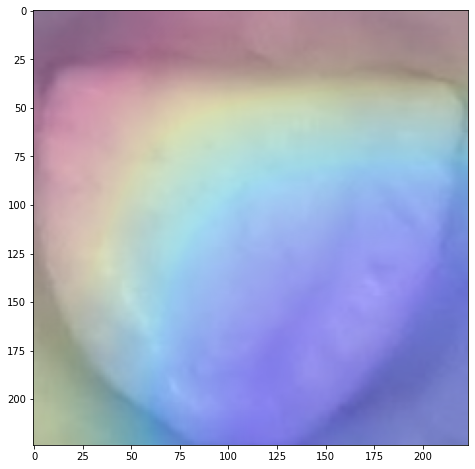

sigmoid output: [[7.9651e-11 1.0000e+00]]
prediction: non cancer


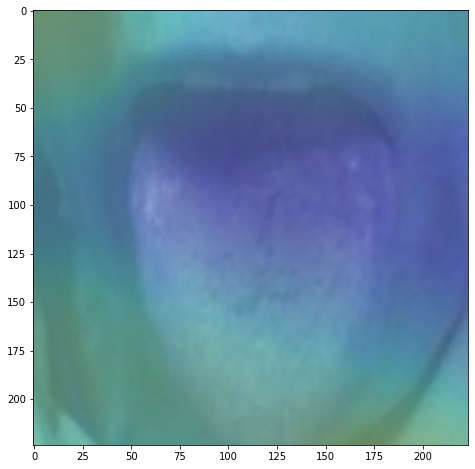

sigmoid output: [[3.3744405e-13 1.0000000e+00]]
prediction: non cancer


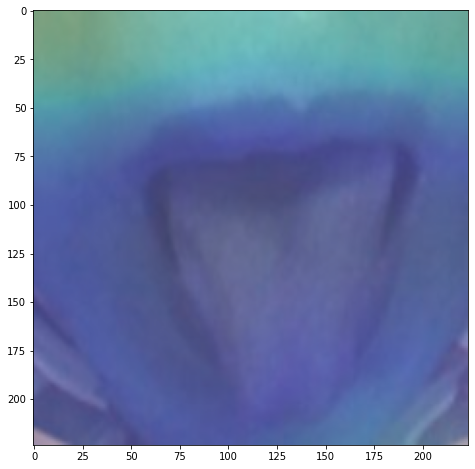

sigmoid output: [[4.233484e-12 1.000000e+00]]
prediction: non cancer


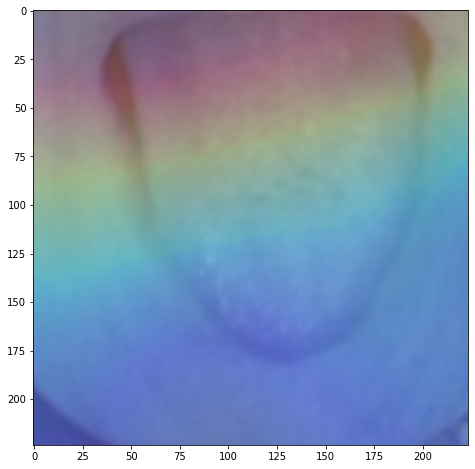

sigmoid output: [[6.896631e-17 1.000000e+00]]
prediction: non cancer


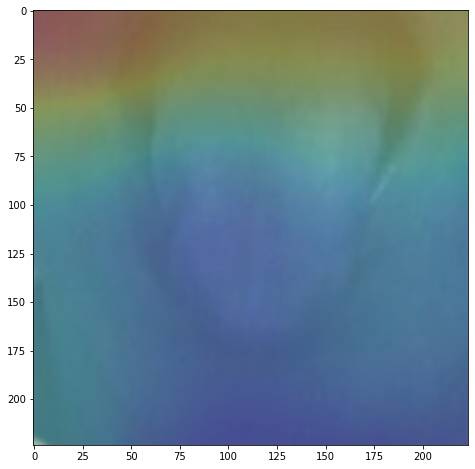

sigmoid output: [[4.879095e-07 9.999995e-01]]
prediction: non cancer


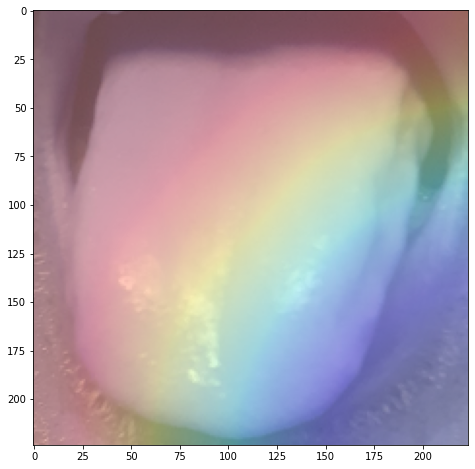

sigmoid output: [[3.804038e-08 1.000000e+00]]
prediction: non cancer


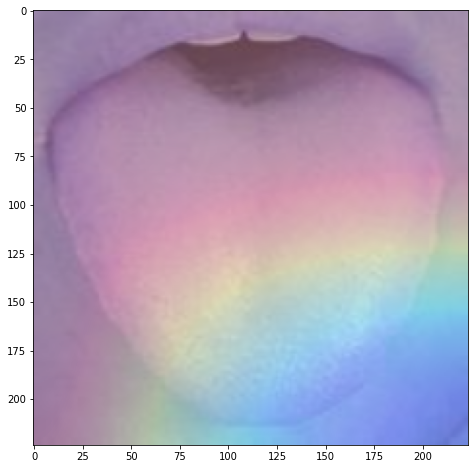

sigmoid output: [[2.3477881e-15 1.0000000e+00]]
prediction: non cancer


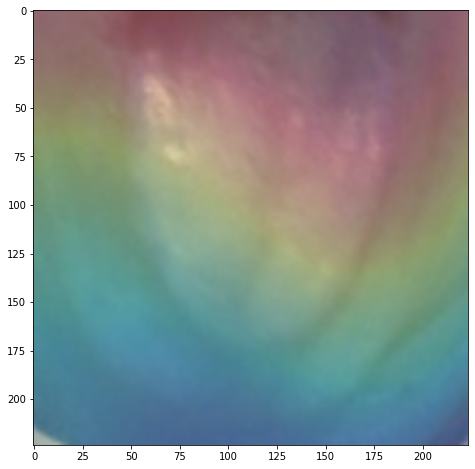

In [ ]:
arr=['nc10.jpg','nc138.jpg', 'nc166.jpg', 'nc38.jpg', 'nc66.jpg', 'nc94.jpg', 'nc110.jpg', 'nc139.jpg', 'nc167.jpg', 'nc39.jpg', 'nc67.jpg', 'nc95.jpg']
for i in arr:
  convert_and_classify(i)


sigmoid output: [[0.89659077 0.10340922]]
prediction: cancer


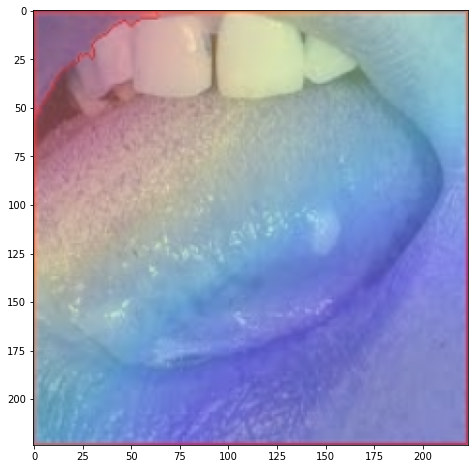

sigmoid output: [[0.9021786  0.09782146]]
prediction: cancer


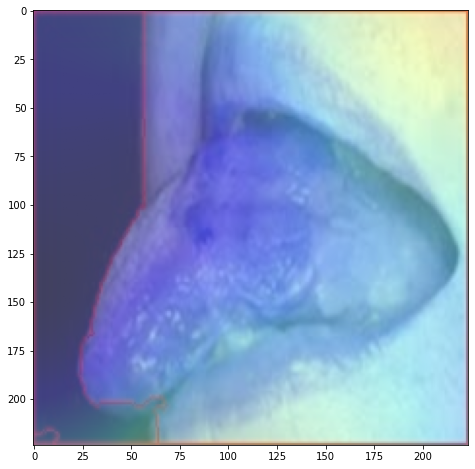

sigmoid output: [[0.6514001  0.34859985]]
prediction: cancer


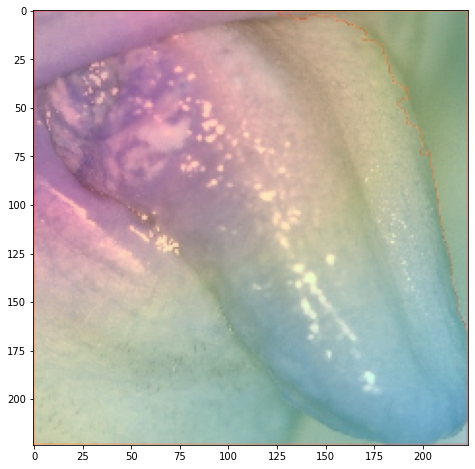

sigmoid output: [[0.98245484 0.01754514]]
prediction: cancer


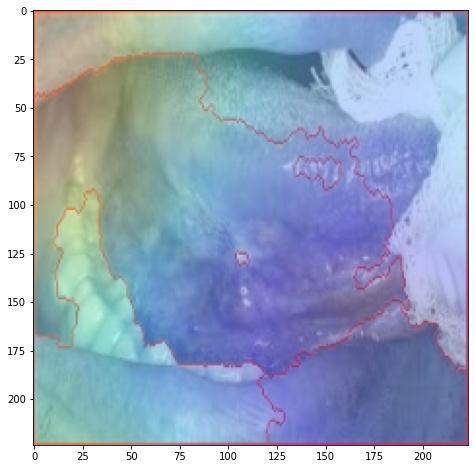

sigmoid output: [[0.678721   0.32127902]]
prediction: cancer


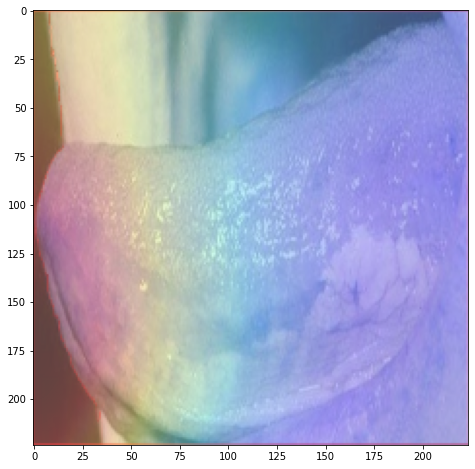

sigmoid output: [[0.9211559  0.07884401]]
prediction: cancer


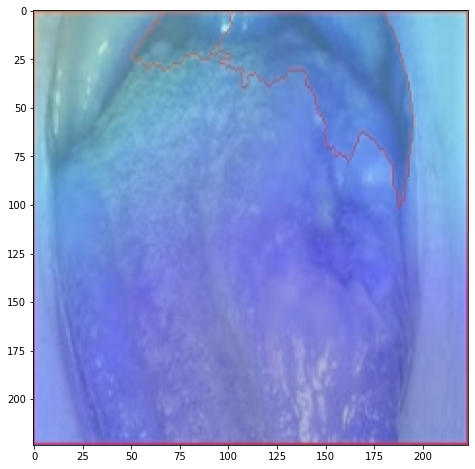

In [ ]:
convert_and_classify('nc64.jpg')
convert_and_classify('nc120.jpg')
convert_and_classify('nc85.jpg')
convert_and_classify('nc109.jpg')
convert_and_classify('nc48.jpg')
convert_and_classify('nc88.jpg')